# The methane global cycle and estimation of emissions



## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Define model class

The global $CH_4$ cycle is studied using a 2-box model. The boxes represent the Northern and Southern hemispheres. $CH_4$ masses are driven by surface emissions, chemical losses and interhemispheric transport.

Emissions undergo seasonal variations.

In [2]:
class Model:
    """2-box model to study global CH4 cycle with simple data assimilation.
    TO DO NEXT:
    - MAKE IT POSSIBLE TO HANDLE OBSERVATIONS OF SELF.CONC[1]
    - READ OBS IN EXTERNAL FILE
    - SIMPLIFY MANAGEMENT OF TIME: self.time vs day...
    """
    
    def __init__(self, nmembers=1):
        self.nmembers = nmembers
        self.conc = np.ones((2,self.nmembers))*20000.
        self.dt = 1.                   # in days
        self.time = 0.
        self.kflux = 1./(1.5*365)      # interhemisphere transport time
        self.loss = 1./(10.*365)       # life time 10 years
        self.conc_series = []
        self.time_series = []
        self.variability=[]
        
        # Baseline emission and transport rates
        self.base_Emissions  = np.outer( np.array([10.,1.]), np.ones(self.nmembers) )  # emissions 
        self.both_Hemisphere = np.outer( np.array([1.,-1.]), np.ones(self.nmembers) )  # transport directions
        self.transport_param = np.outer( np.array([0.2,0.1]), np.ones(self.nmembers) ) # transport rates
        
        # add seasonal variability of emissions (importance of seasonality : multiply by a factor)
        self.factor_variability=0.5     
        self.variability= np.sin(2*np.pi*np.arange(0,365)/365.)*self.factor_variability*np.array([[1.],[-1.]])
        #self.both_Hemisphere = self.both_Hemisphere[:,np.newaxis]
        self.variability = self.variability[:,:,np.newaxis]

        # For nudging. Those parameters are prescribed at call of run function.
        self.k_nudging = 0.
        self.day_interval = 0
        
        # To compute MSE
        self.mse = np.zeros(self.nmembers)
        
        # For ensembles. Perturb emission amplitudes and inter-hemispheric transport rates.
        if self.nmembers > 1: 
            zero2 = np.zeros(2)
            iden2 = np.eye(2)
            self.base_Emissions += 1.5 * np.transpose(np.random.multivariate_normal(zero2,iden2,self.nmembers))
            self.transport_param += 0.02 * np.transpose(np.random.multivariate_normal(zero2,iden2,self.nmembers))
            
    def initialize(self, xc, day=0):
        """reinitialize model. xc here is a 2-entry array."""
        for ie in range(self.nmembers):
            self.conc[:,ie] = xc
        self.time = day
        
    def rungekutta(self, func_in):
        """update concentration with a Runge-Kutta 4 step.
        func_in is the RHS term of the equation. func_in only takes a conc array as argument."""
        k1 = func_in(self.conc) * self.dt
        xtmp = self.conc + 0.5 * k1
        k2 = func_in(xtmp) * self.dt
        xtmp = self.conc + 0.5 * k2
        k3 = func_in(xtmp) * self.dt
        xtmp = self.conc + k2
        k4 = func_in(xtmp) * self.dt
        self.conc += (k1+2*k2+2*k3+k4)/6.
        
    def rhs(self, xc):
        """Compute the right-hand-side term of the 2-box differential equation."""
        rhs_out = np.empty_like(xc)
        flux1 = -self.kflux*xc[0,] + self.kflux*xc[1,]
        ### Emissions !!!
        # is the accum of base emissions + seasonal variability (based on the day )
        day = int(self.time)
        Emissions = self.base_Emissions * (1 + self.variability[:,day%365] )       
        rhs_out = Emissions - self.loss*xc + flux1*self.both_Hemisphere*self.transport_param
        return rhs_out
    
    def nudging_coefficient(self, day, obsday):
        """Compute the nudging coefficient K. K is a hat function taking values
        0 at day = obsday - or + day_interval, and self.k_nudging at day = obsday.
        ----------
        Parameters:
        ----------
        day: simulation day (integer of self.time)
        obs_day: day of observation
        -------
        Returns:
        -------
        nudging coefficient. 
        """
        a = obsday-day
        a = 1. - np.sign(a)*a/np.float(self.day_interval)
        a = np.maximum(a,0.)
        return self.k_nudging*a

    def nudging_term(self, xc):
        """Compute the nudging term using all eligible observations.
        IMPORTANT: AS TO NOW, IT IS HARDCODED THAT INDEX 0 OF SELF.CONC IS OBSERVED. THIS MUST BE IMPROVED."""
        nudg_out = np.zeros_like(xc)
        day = int(self.time)
        check_obs, obs_days, obs_values = self.observation(day)      # get obs. days and values for the day
        if check_obs == True:
            nobs = len(obs_days)
            for io in range(nobs):
                obsday = obs_days[io]
                obsval = obs_values[io]
                nudg_out[0,] += self.nudging_coefficient(day, obsday)*(obsval-self.conc[0,])           
        return nudg_out
        
    def rhs_with_nudging(self, xc):
        """return RHS term expanded with nudging term. This is meant to be argument of the rungekutta function."""
        return self.rhs(xc) + self.nudging_term(xc)
    

    def run(self, days, mode='free', method='nudging', k_nudging=0.2, day_interval=20):
        """Run the model time integration, with or without data assimilation.
        ----------
        Parameters:
        ----------
        days: number of days of integration
        mode: 'free' (default) or 'assim'.
        method: assimilation method. 'substitution' or 'nudging' (default)
        k_nudging: nudging coefficient. Default: 0.2
        day_interval: time lag around observation time, over which nudging is applied. Default: 20
        -------
        Returns:
        -------
        no explicit outputs. Changes class attributes conc, conc_series, time, time_series
        """
        nsteps = int(days/self.dt)     
        self.conc_series = np.zeros((2, nsteps+1, self.nmembers))
        self.conc_series[:,0,:] = self.conc
        self.time_series = np.empty(nsteps+1)
        self.time_series[0] = self.time
        
        if mode == 'free':
            nobs = 0
            for it in range(nsteps):
            #for ie in range(self.nmembers):
                self.time += self.dt
                self.rungekutta(self.rhs)
                self.conc_series[:,it+1,:] = self.conc
                self.time_series[it+1] = self.time
                day = int(self.time)
                check_obs, obs_days, obs_values = self.observation(day)
                if check_obs == True:
                    nobs += 1
                    self.mse += ( self.conc[0,] - obs_values[0] )**2
            if nobs is not 0:
                self.mse /= nobs
                self.mse = np.sqrt(self.mse)
            
        if mode == 'assim' and method == 'substitution':
            for it in range(nsteps):
            #for ie in range(self.nmembers):
                self.time += self.dt
                self.rungekutta(self.rhs)
                day = int(self.time)
                check_obs, obs_days, obs_values = self.observation(day)
                if check_obs == True:
                    self.conc[0,] = obs_values[0]
                self.conc_series[:,it+1,:] = self.conc
                self.time_series[it+1] = self.time
            
        if mode == 'assim' and method == 'nudging':
            self.k_nudging = k_nudging
            self.day_interval = day_interval
            for it in range(nsteps):
                self.time += self.dt
                self.rungekutta(self.rhs_with_nudging)
                self.conc_series[:,it+1,:] = self.conc
                self.time_series[it+1] = self.time
    
    def read_obs(self):
        day_list = [200, 400, 600, 800]
        obs_val = [21850, 21400, 21745, 21520]
        return day_list, obs_val
    
    
    def observation(self, day):
        """Check if an obs is available for this day and get value.
        In future designs, the first two arrays should be read externally."""
        day_list, obs_val = self.read_obs()
        check = False
        obsday = []
        obsval = []
        for day_tmp in day_list:
            if day in range(day_tmp-self.day_interval, day_tmp+self.day_interval+1):
                check = True
                obsday = obsday + [day_tmp]
                io = day_list.index(day_tmp)
                obsval = obsval + [obs_val[io]]   
        return check, obsday, obsval
                
    def plot_series(self):
        x, y = self.read_obs()

        plt.figure(figsize=(12,4))
        for ie in range(self.nmembers):
            plt.subplot(1,2,1)
            plt.plot(self.time_series,self.conc_series[0,:,ie],'black',linewidth=1.)
            plt.plot(x,y,'bo')
            plt.subplot(1,2,2)
            plt.plot(self.time_series,self.conc_series[1,:,ie],'red',linewidth=1.)
        plt.show()

## 1. Spin-up

Spin-up consists in running the model from poor initial conditions to let it reach sort of a statistical equilibrium. Here, the model is started with $CH_4$ quantities of 0 in both hemisphere, what is obviously inaccurate, but after a few years, the model reaches its equilibrium.

More precisely, the model is run over 5000 days. The final concentration is stored in an array called `conc_init` which will be used later to initiate other simulations.

In [3]:
toto = Model()
toto.run(365*100)
conc_init = toto.conc[:,0]

In [4]:
toto = Model()
toto.initialize(conc_init, day=0.)
toto.run(1000)

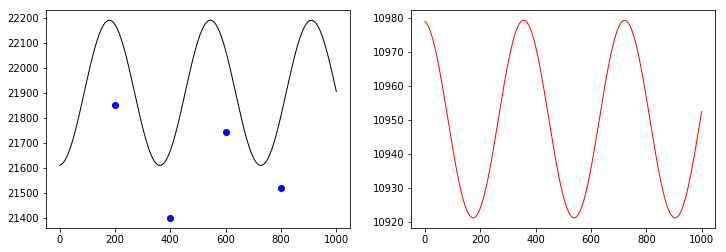

In [5]:
toto.plot_series()

## 2. Assimilation of observations (part 1)

At day 200 an observation of $CH_4$ in the Northern hemisphere tells us that $CH_4$ quantity is $21850\pm 50$. How can you take this information into account in order to correct the model trajectory?

### 2.1. Brute force: replacing model variable with observation

Try to replace the observed model variable directly with the observation value.

In [6]:
titi = Model()
titi.initialize(conc_init, day=0.)
titi.run(1000, mode='assim', method='substitution')

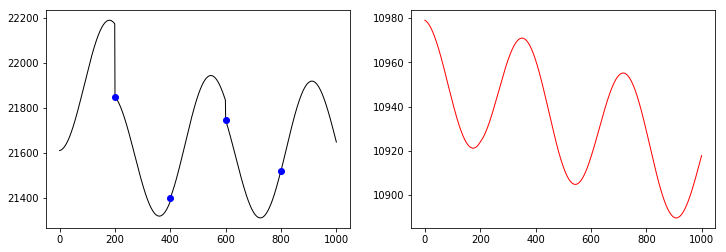

In [7]:
titi.plot_series()

### 2.2. More subtle: nudging

Nudging consists in replacing the original model equation:
$$ \frac{dX}{dt} = f(X,t) $$
by the following equation:
$$ \frac{dX}{dt} = f(X,t) + K (X_{obs}(t) - X(t) )$$
where $X_{obs}(t)$ is the observation values of $X(t)$ and $K$ is a nudging coefficient. Note that:

- In absence of observation, the nudging term does not appear and the the original equation is retrieved;
- Nudging at the single time of observation (i.e., once in the simulation) has little impact. Usually, the nudging term is activated some time before the observation time, with $K$ increasing from 0 to its prescribed value, then nudging is progressively deactivated by decreasing $K$ to 0.

Try that!

In [8]:
titi = Model()
titi.initialize(conc_init, day=0.)
titi.run(1000, mode='assim', method='nudging', k_nudging = 0.05, day_interval = 50)

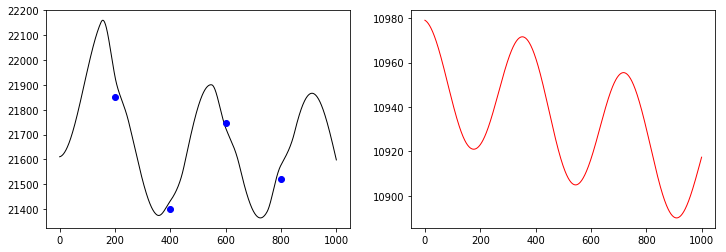

In [9]:
titi.plot_series()

## 3. Assimilation of observations (part 2)

To account for observation uncertainty and obtain an estimation of the simulation uncertainty, a common method is to use ensembles. The idea is that the ensemble spread reflects the simulation uncertainty. At observation time, one can combine the ensemble and the observation based on their relative uncertainties.

### 3.1. Ensemble simulation

We create a new instance of the `Model` class with several ensemble members. Members are initialized with the previously computed `conc_init` value. Then the model is run in ensemble mode over the first 200 days. Members are plotted.

In [10]:
toto_ens = Model(nmembers = 100)
toto_ens.initialize(conc_init)

In [11]:
toto_ens.run(1000)

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


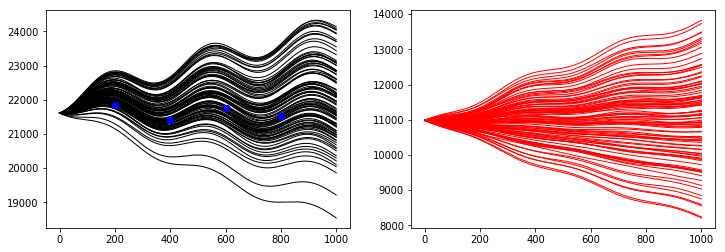

In [12]:
toto_ens.plot_series()

Well of course here all the ensemble members are the same because we did not introduce the simulation of uncertainties. Please introduce those. Assume first that emissions are the primary source of uncertainty. Then, perhaps the interhemispheric exchange rates?

In [13]:
toto_ens.mse

array([ 824.34803692,  965.76366168,  717.09843617,  609.69202537,
        166.65124833,  440.64340932,  883.03837699,  367.68773313,
        465.4353595 , 1293.52380593,  310.810623  ,  350.61213572,
        249.9906179 ,  205.02947223,  266.37361437,  368.42602181,
        642.60442447,  195.21179181,  331.48114811, 1571.31301368,
        343.22991263, 1064.46105286,  752.61829091,  573.92781042,
        354.80289547,   92.78447525,  462.06511175, 1767.50239385,
        187.76651457,  844.69020006,  966.89592602,  643.17283204,
        390.87318477,  114.19008066,  227.43673216, 1119.60557683,
        161.49946187,  437.62696974,  424.735656  ,  443.20322549,
        483.09429694,  227.10205725,  319.23357055,  346.91752791,
        745.90225113, 1519.81277604,   72.78283703,  464.27193497,
        209.37174694,  339.17270992,  928.69154348,  517.25542606,
        965.05580446,  975.47123171, 1617.32747816, 1068.90124849,
       1553.5285707 ,  365.56985983,  161.66231796,  207.56719

In [14]:
np.argmin(toto_ens.mse)

46

In [15]:
toto_ens.mse[82]

1025.2058071980066

### 3.2. Comparison of the ensemble and the observation

We reinitialize the ensemble and run it until the first observation. Then we plot the histogram of the ensemble, with probability density function of observation (assumed Gaussian).

In [16]:
toto_ens = Model(nmembers = 100)
toto_ens.initialize(conc_init)

In [17]:
day_obs, val_obs = toto_ens.read_obs()
iobs = 0
toto_ens.run(day_obs[iobs])

In [18]:
def gauss(xarr, xm, std):
    """return gaussian function of sorted array xarr, with mean xm and standard deviation std."""
    s = (xarr - xm)/std
    s = 0.5*s*s
    s = np.exp(-s)
    dx = np.roll(xarr, -1) - xarr
    dx[-1] = dx[-2]
    s /= np.sum(s*dx)
    return s

In [19]:
xxx = np.arange(20000., 24000., 10.)
gau = gauss(xxx, val_obs[iobs], 50.)

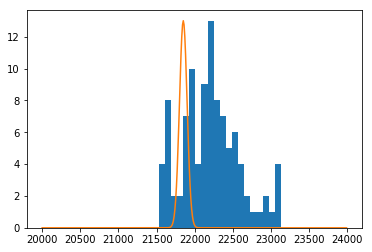

In [20]:
n, bins, patches = plt.hist(toto_ens.conc[0,:], bins=20)
gau *= np.max(n)/np.max(gau)
plt.plot(xxx, gau)

In [100]:
val_obs

[21850, 21400, 21745, 21520]

### 3.3. Combining the ensemble and the observation



This requires some theoretical background to be introduced in class.

#### Compute weights

In [101]:
def compute_weight(conc, obsmean, obsstd):
    w = ( conc[0,:] - obsmean ) / obsstd
    w = np.exp(-0.5*w*w)
    w /= np.sum(w)
    return w

In [102]:
weights = compute_weight(toto_ens.conc, val_obs[iobs], 50.)

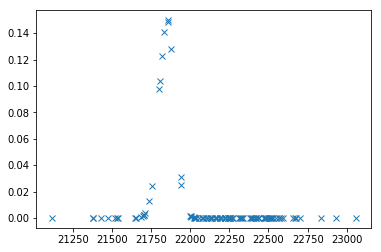

In [103]:
plt.plot(toto_ens.conc[0,:], weights, 'x')

#### Resample

In [104]:
nmem = np.shape(toto_ens.conc)[1]
index = [0]*nmem
cdf = np.empty(nmem)
for i in range(nmem):
    cdf[i] = np.sum(weights[:i+1])
urand = np.random.random()/nmem
for i in range(nmem):
    index[i] = np.searchsorted(cdf, urand)
    urand += 1./nmem

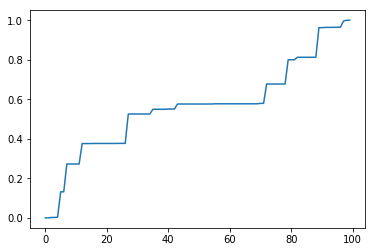

In [105]:
plt.plot(cdf)

In [106]:
toto_ens.conc = toto_ens.conc[:,index]

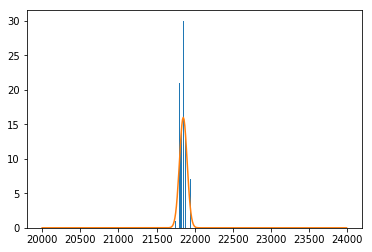

In [107]:
plt.hist(toto_ens.conc[0,:], bins=20)
plt.plot(xxx, gau)

In [108]:
toto_ens.run(day_obs[iobs+1]-day_obs[iobs])

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


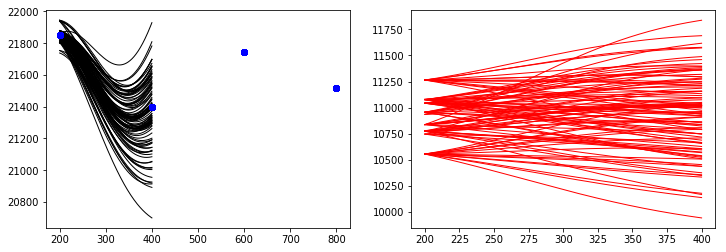

In [109]:
toto_ens.plot_series()

In [87]:
index

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 13,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 40,
 55,
 76,
 84,
 87,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94,
 94]